# Analyzing COVID-19's Effect on Student Engagement for Online Schooling
### Joshua Hess

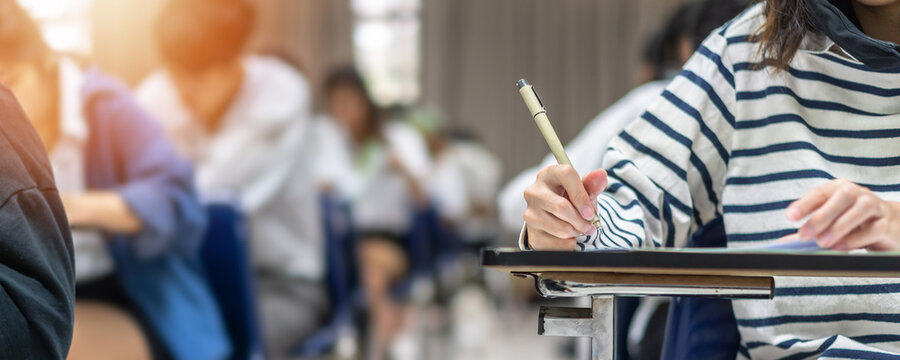

When the COVID-19 Pandemic hit the world in early 2020, one of the fields that was hit the hardest was education. Many schools had to quickly switch from in-person synchronous instruction to remote asynchronous instruction. Students had to learn how to adapt to online schooling, and it had a negative effect in schools across the whole country. One of the things affected the most by COVID was **student engagement**, which measures how 'engaged' or 'focused' a student is on their schoolwork. This project will take a closer look at how COVID affected student engagement throughout late 2019 and 2020. 

Now, let's load in a few of our datasets and take an initial look at them:

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import districts and products info
districts = pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv')
products = pd.read_csv('/kaggle/input/learnplatform-covid19-impact-on-digital-learning/products_info.csv')

# Print out basic information
print("Districts Dataset:\n")
print(districts.head(5))
print(districts.info())

print("\nProducts Dataset:\n")
print(products.head(5))
print(products.info())

Districts Dataset:

   district_id     state  locale pct_black/hispanic pct_free/reduced  \
0         8815  Illinois  Suburb           [0, 0.2[         [0, 0.2[   
1         2685       NaN     NaN                NaN              NaN   
2         4921      Utah  Suburb           [0, 0.2[       [0.2, 0.4[   
3         3188       NaN     NaN                NaN              NaN   
4         2238       NaN     NaN                NaN              NaN   

  county_connections_ratio    pp_total_raw  
0                [0.18, 1[  [14000, 16000[  
1                      NaN             NaN  
2                [0.18, 1[    [6000, 8000[  
3                      NaN             NaN  
4                      NaN             NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state 

# Cleaning Phase

## Aggregating and Cleaning Engagement Data

Before we can begin a proper analysis, we need to organize our data together. In the `engagement_data` folder, we have `.csv` files of every district, with the district's number being the name of the file. Let's combine all of these CSV's into one overall DataFrame. As we add the data, we'll add an additional column named `district_id` that contains the ID of the district for that particular observation:

In [2]:
# Import libraries for file management
import os
import glob

# Add all engagement_data CSV's into a list
filepath = "/kaggle/input/learnplatform-covid19-impact-on-digital-learning/engagement_data"
files = glob.glob(filepath + "/*.csv")

# Initialize empty list to hold all engagement_data DataFrames
data = []

# For each CSV in 'files', add it to the 'data' list and create a new column 'district_id'
for file in files:
    df = pd.read_csv(file)  # Read in DataFrame
    filename = os.path.splitext(file)  # # Split filename and extension
    df['district_id'] = os.path.basename(filename[0])  # Extract district ID from CSV filename tuple
    data.append(df)  # Add new column to new list

# Concatenate all DataFrames into one 'engagement_data' DataFrame
engagement_data = pd.concat(data)
engagement_data['district_id'] = engagement_data['district_id'].astype('int64')  # Make the district ID's be integers
print(engagement_data.head(10))
print(engagement_data.info())

         time    lp_id  pct_access  engagement_index  district_id
0  2020-01-01  92844.0        0.01              0.68         6345
1  2020-01-01  64838.0        0.01              0.68         6345
2  2020-01-01  94058.0        0.00               NaN         6345
3  2020-01-01  26488.0        0.03             26.21         6345
4  2020-01-01  32340.0        0.01              0.11         6345
5  2020-01-01  95731.0        0.20             40.96         6345
6  2020-01-01  92918.0        0.01              4.54         6345
7  2020-01-01  17307.0        0.00               NaN         6345
8  2020-01-01  96255.0        0.01              0.11         6345
9  2020-01-01  83862.0        0.01              0.11         6345
<class 'pandas.core.frame.DataFrame'>
Index: 22324190 entries, 0 to 41427
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time              object 
 1   lp_id             float64
 2   pct_access        float64
 3   engageme

Now we must clean up our data. Let's begin with our `engagement_data` table. First, let's check how many missing values are in each column:

In [3]:
# Print sum of all missing values
print(engagement_data.isnull().sum())

# Check if all observations with a missing value for 'pct_access' also has a missing value for 'engagement_index'
missing_pct = engagement_data[engagement_data['pct_access'].isna()]
print("\nNumber of observations with missing pct_access: " + str(len(missing_pct.index)))

num_of_null_indexes = str(len(missing_pct[missing_pct['engagement_index'].isna()]))
print("Number of missing values for engagement_index: " + num_of_null_indexes)

time                      0
lp_id                   541
pct_access            13447
engagement_index    5378409
district_id               0
dtype: int64

Number of observations with missing pct_access: 13447
Number of missing values for engagement_index: 13447


Notice above that for every time we had a `pct_access` missing, our `engagement_index` was also missing. We can assume that if the `pct_access` is missing, students likely didn't use any learning products that day, which means that there was no `engagement_index` to be measured. For all of these observations, we'll replace both values with 0:

In [4]:
# Conditional statement for both 'engagement_index' and 'pct_access' being missing
both_missing = (engagement_data['pct_access'].isna()) & (engagement_data['engagement_index'].isna())

# Replace NA's in both columns with 0
engagement_data.loc[both_missing, 'pct_access'] = engagement_data.loc[both_missing, 'pct_access'].fillna(0)
engagement_data.loc[both_missing, 'engagement_index'] = engagement_data.loc[both_missing, 'engagement_index'].fillna(0)

# Check missing values
print(engagement_data.isna().sum())

time                      0
lp_id                   541
pct_access                0
engagement_index    5364962
district_id               0
dtype: int64


For the time being, we'll fill in all other NA's with zero. For `lp_id`, we'll drop those observations because the rows with missing values for `lp_id` only make up about 0.0024% of the total dataset. 

In [5]:
# Drop rows where 'lp_id' is missing
engagement_data = engagement_data.dropna(subset=['lp_id'])

# Fill all other NA's with 0
engagement_data = engagement_data.fillna(0)

# Check the DataFrame to verify missing values are taken care of
print(engagement_data.isna().sum())

time                0
lp_id               0
pct_access          0
engagement_index    0
district_id         0
dtype: int64


Lastly, let's format the `time` column as a datetime datatype, which will help with plotting time series later:

In [6]:
# Convert time to datetime
engagement_data['time'] = pd.to_datetime(engagement_data['time'])

## Cleaning District Info Data

Now, we can move onto cleaning our other two DataFrames. Let's begin with `districts_info.csv`. First, let's get a quick glance at the DataFrame and see the number of missing values in each column:

In [7]:
# Print information on districts_info DataFrame
print(districts.info())

# Print missing values
print(districts.isna().sum())

# Print value_counts() for percent columns
for column in ['pct_black/hispanic', 'pct_free/reduced', 'county_connections_ratio', 'pp_total_raw']:
    print("\nValue counts for " + column + ":\n")
    print(districts.value_counts(column))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state                     176 non-null    object
 2   locale                    176 non-null    object
 3   pct_black/hispanic        176 non-null    object
 4   pct_free/reduced          148 non-null    object
 5   county_connections_ratio  162 non-null    object
 6   pp_total_raw              118 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.9+ KB
None
district_id                   0
state                        57
locale                       57
pct_black/hispanic           57
pct_free/reduced             85
county_connections_ratio     71
pp_total_raw                115
dtype: int64

Value counts for pct_black/hispanic:

pct_black/hispanic
[0, 0.2[      116
[0.2, 0.4[     24
[0.4, 0.6[     17
[0.6,

One thing to notice about the above output is that our percentages aren't formatted as specific numbers, but as ranges. This was done to protect the identity of individual school districts, so we can rename these ranges to make it more clear what each percentage is:

In [8]:
# Create dictionaries for renaming
blackhisp_freereduced_dict = {
    '[0, 0.2[' : '0% - 20%',
    '[0.2, 0.4[' : '20% - 40%',
    '[0.4, 0.6[' : '40% - 60%',
    '[0.6, 0.8[' : '60% - 80%',
    '[0.8, 1.0[' : '80% - 100%'
}

raw_ppl_dict = {
    '[8000, 10000[' : '8k-10k',
    '[10000, 12000[' : '10k-12k',
    '[12000, 14000[' : '12k-14k',
    '[14000, 16000[' : '14k-16k',
    '[16000, 18000[' : '16k-18k',
    '[6000, 8000[' : '6k-8k',
    '[18000, 20000[' : '18k-20k',
    '[20000, 22000[' : '20k-22k',
    '[22000, 24000[' : '22k-24k',
    '[4000, 6000[' : '4k-6k',
    '[32000, 34000[' : '32k-34k'
}

county_ratio_dict = {
    '[0.18, 1[' : '18%-100%',
    '[1, 2[' : '100%-200%'
}

# Rename all observations with dictionaries
districts['pct_black/hispanic'] = districts['pct_black/hispanic'].replace(blackhisp_freereduced_dict)
districts['pct_free/reduced'] = districts['pct_free/reduced'].replace(blackhisp_freereduced_dict)
districts['pp_total_raw'] = districts['pp_total_raw'].replace(raw_ppl_dict)
districts['county_connections_ratio'] = districts['county_connections_ratio'].replace(county_ratio_dict)

# Check DataFrame
print(districts.head())

   district_id     state  locale pct_black/hispanic pct_free/reduced  \
0         8815  Illinois  Suburb           0% - 20%         0% - 20%   
1         2685       NaN     NaN                NaN              NaN   
2         4921      Utah  Suburb           0% - 20%        20% - 40%   
3         3188       NaN     NaN                NaN              NaN   
4         2238       NaN     NaN                NaN              NaN   

  county_connections_ratio pp_total_raw  
0                 18%-100%      14k-16k  
1                      NaN          NaN  
2                 18%-100%        6k-8k  
3                      NaN          NaN  
4                      NaN          NaN  


Unfortunately since the values of all of these columns depend strongly on the details of the school district, there's no reliable way to impute values for these columns. We can assume that this information was not reported when the data was being collected, so let's fill all NA values in this DataFrame with 'Not reported':

In [9]:
# Fill all NA values with 'Not reported'
districts = districts.fillna('Not reported')
print(districts.info())  # Check DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   district_id               233 non-null    int64 
 1   state                     233 non-null    object
 2   locale                    233 non-null    object
 3   pct_black/hispanic        233 non-null    object
 4   pct_free/reduced          233 non-null    object
 5   county_connections_ratio  233 non-null    object
 6   pp_total_raw              233 non-null    object
dtypes: int64(1), object(6)
memory usage: 12.9+ KB
None


## Cleaning Educational Product Info

Now, we can clean our last DataFrame for this project: `products`. Just like we did with the `districts` DataFrame, let's look at the missing values:

In [10]:
# Print information on products DataFrame
print(products.info())

# Print missing values
print(products.isna().sum())

# Rename column names to match other DataFrames
rename_dict = {
    'LP ID' : 'lp_id',
    'URL' : 'url',
    'Product Name' : 'name',
    'Provider/Company Name' : 'prov_comp_name',
    'Sector(s)' : 'sector',
    'Primary Essential Function' : 'pef'
}

products = products.rename(columns = rename_dict)  # Replace column names

# Fill all NA's with 'Not reported'
products = products.fillna('Not reported')
print(products.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LP ID                       372 non-null    int64 
 1   URL                         372 non-null    object
 2   Product Name                372 non-null    object
 3   Provider/Company Name       371 non-null    object
 4   Sector(s)                   352 non-null    object
 5   Primary Essential Function  352 non-null    object
dtypes: int64(1), object(5)
memory usage: 17.6+ KB
None
LP ID                          0
URL                            0
Product Name                   0
Provider/Company Name          1
Sector(s)                     20
Primary Essential Function    20
dtype: int64
   lp_id                           url          name         prov_comp_name  \
0  13117    https://www.splashmath.com   SplashLearn          StudyPad Inc.   
1  66933          https

The only missing values in our `products` DataFrame is one missing company name, and 20 missing sectors/PEF's (primary essential functions). There's no way to impute these values, so we'll fill all NA's with 'Not reported,' similar to what we did for the `districts` DataFrame. Now that all three DataFrames are cleaned, we can start analyzing the data to answer the questions we were given for the project.

# Analysis Phase

Before we get into answering the specific questions that the project posed, let's take an initial look at our data and get a feel for what we're working with. First, let's look at the distribution of states that are included in the data:

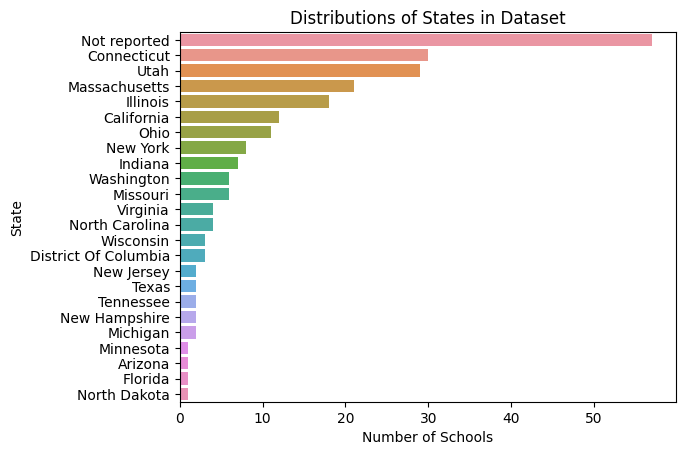

lp_id
95731.0    78295
99916.0    77304
26488.0    76214
28504.0    75814
33185.0    73778
72758.0    72800
32213.0    72321
13496.0    71122
69827.0    70979
69863.0    70566
Name: count, dtype: int64


In [11]:
# Merge engagement_data with products
engagement_products = pd.merge(engagement_data, products, on = 'lp_id', how = 'left')
engagement_districts = pd.merge(engagement_data, districts, on = 'district_id', how = 'left')

# Plot the count of all states
sns.countplot(data = districts, y = 'state', order = districts.state.value_counts(ascending = False).index)
plt.xlabel('Number of Schools')
plt.ylabel('State')
plt.title('Distributions of States in Dataset')
plt.show()

print(engagement_data['lp_id'].value_counts().head(10))

We can see from the above graph that our data is not evenly distributed across all states in the US. The most common states are Connecticut, Utah, and Massachusetts. States like North Dakota, Florida, and Arizona only have 1-2 schools in this dataset, meaning that those states are severely underrepresented. This isn't an immediate issue, but we need to keep this in mind when comparing statistics between states later.

Now, let's create a line plot showing the engagement index over time, colored by which learning product the engagement is being measured for:

     lp_id              name
49   99916      Google Drive
140  13496         Wikipedia
157  32213  Google Classroom


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

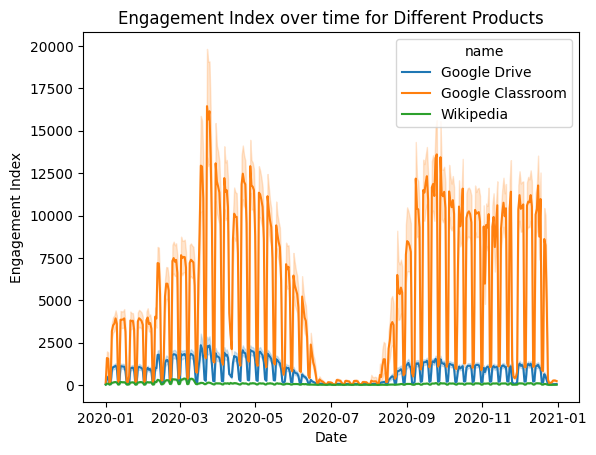

In [12]:
# Narrow down top products
top_ids = [99916.0, 32213.0, 13496.0]
top_products = products.loc[products['lp_id'].isin(top_ids), ['lp_id', 'name']]
print(top_products)

# Filter the engagement_data DataFrame for specific lp_id
engagement_filtered = engagement_products.loc[engagement_products['lp_id'].isin(top_ids), ['time', 'lp_id', 'name', 'engagement_index']]

# Plot time series of engagement_index over time, colored by lp_id
sns.lineplot(data = engagement_filtered, x = 'time', y = 'engagement_index', hue = 'name')
plt.title('Engagement Index over time for Different Products')
plt.xlabel('Date')
plt.ylabel('Engagement Index')
plt.show()

## Question 1 - "What is the picture of digital connectivity and engagement in 2020?"

In [13]:
# CODE FOR QUESTION 1

## Question 2 - "What is the effect of the COVID-19 pandemic on online and distance learning, and how might this also evolve in the future?"

In [14]:
# CODE FOR QUESTION 2

## Question 3 - "How does student engagement with different types of education technology change over the course of the pandemic?"

In [15]:
# CODE FOR QUESTION 3

## Question 4 - "How does student engagement with online learning platforms relate to different geography? Demographic context (e.g., race/ethnicity, ESL, learning disability)? Learning context? Socioeconomic status?"

In [16]:
# CODE FOR QUESTION 4

## Question 5 - "Do certain state interventions, practices or policies (e.g., stimulus, reopening, eviction moratorium) correlate with the increase or decrease online engagement?"

In [17]:
# CODE FOR QUESTION 5